# Estimation non paramétrique

Dans cet exercice, nous traitons les données du geyser Old Faithful et nous estimons la densité de probabilité associée à la variable aléatoire de la durée entre deux éruptions.

On étudie les données "Old Faithful Geyser". 

Description: (From R manual):

Waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.

A data frame with 272 observations on 2 variables:

* eruptions : Eruption time in mins
* waiting : Waiting time to next eruption

## References

* Hardle, W. (1991) Smoothing Techniques with Implementation in S. New York: Springer.

* Azzalini, A. and Bowman, A. W. (1990). A look at some data on the Old Faithful geyser. Applied Statistics 39, 357-365.


## Lecture des données

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np
import pylab as pl

In [2]:
sample = ot.Sample.ImportFromCSVFile("faithful.csv", ",")
sample.setDescription(["Index", "Eruption (min)", "Waiting (min)"])

sample[:10]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=3 description=[Index,Eruption (min),Waiting (min)] data=[[1,3.6,79],[2,1.8,54],[3,3.333,74],[4,2.283,62],[5,4.533,85],[6,2.883,55],[7,4.7,88],[8,3.6,85],[9,1.95,51],[10,4.35,85]]

In [3]:
waiting = sample[:, 2]

## Histogramme

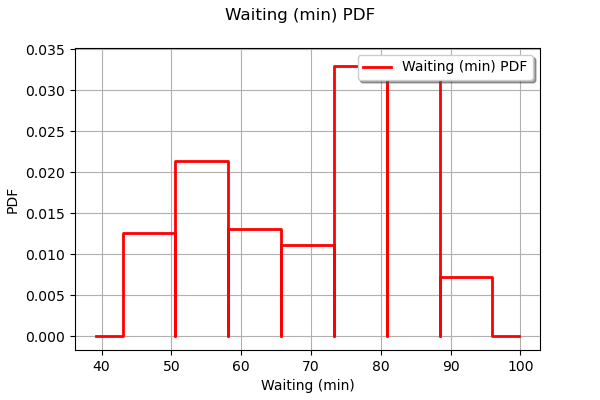

In [4]:
factory = ot.HistogramFactory()

histogram = factory.build(waiting)
histogram.drawPDF()

In [5]:
bandwidth = factory.computeBandwidth(waiting)
bandwidth

9.585431097147616

Configurons la largeur de bande pour fixer une valeur plus petite. 

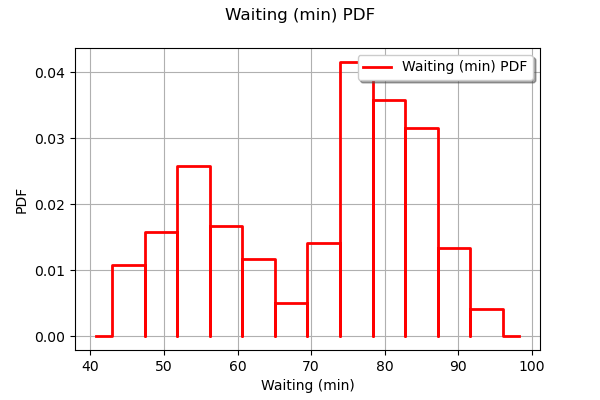

In [6]:
bandwidth = 5.0

histogram = factory.build(waiting, bandwidth)

histogram.drawPDF()

On observe que les données sont représentées plus finement, avec deux modes clairement visibles autour de 55 et 80.

## Estimation à noyau

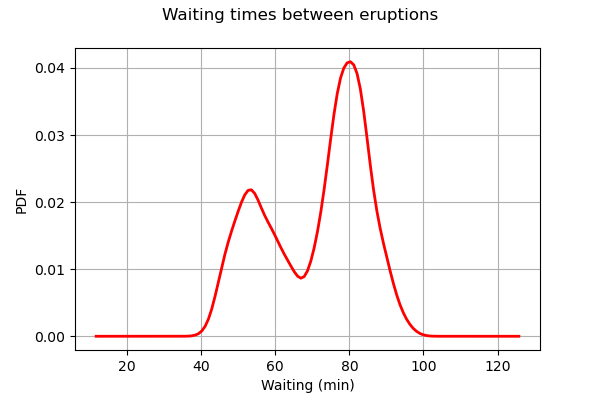

In [7]:
factory = ot.KernelSmoothing()

ks = factory.build(waiting)
graph = ks.drawPDF()
graph.setTitle("Waiting times between eruptions")
graph.setLegends([""])
graph

In [8]:
bandwidth = factory.computeSilvermanBandwidth(waiting)
bandwidth

class=Point name=Unnamed dimension=1 values=[5.79819]

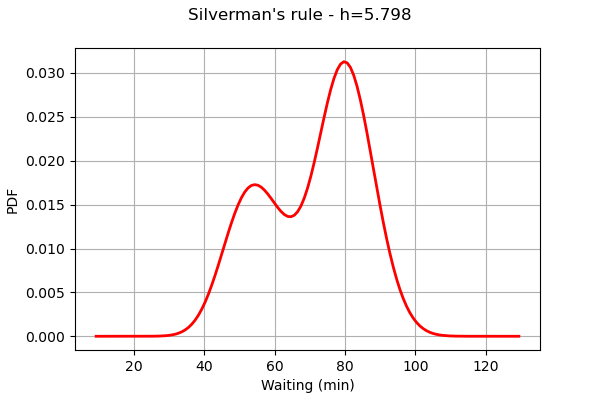

In [9]:
bandwidth = factory.computeSilvermanBandwidth(waiting)
ks = factory.build(waiting, bandwidth)
graph = ks.drawPDF()
graph.setTitle("Silverman's rule - h=%.3f" % (bandwidth[0]))
graph.setLegends([""])

graph

## Comparaison de l'histogramme et du KDE

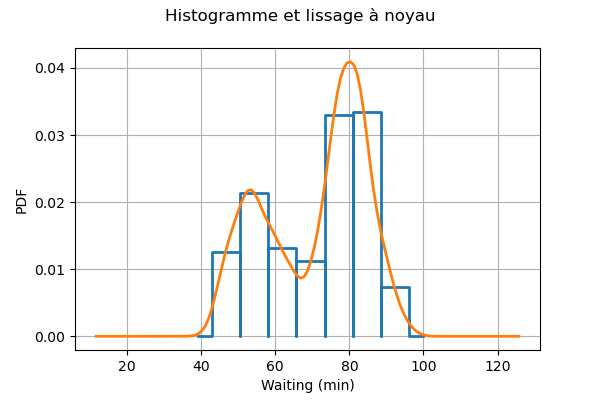

In [10]:
factory = ot.HistogramFactory()
histogram = factory.build(waiting)
graph = histogram.drawPDF()
#
factory = ot.KernelSmoothing()
ks = factory.build(waiting)
curve = ks.drawPDF()
graph.add(curve)
#
graph.setColors(ot.DrawableImplementation_BuildDefaultPalette(2))
graph.setLegends([""])
graph.setTitle("Histogramme et lissage à noyau")
graph

## Exercice 1 : sensibilité du lissage à noyau à la largeur de bande


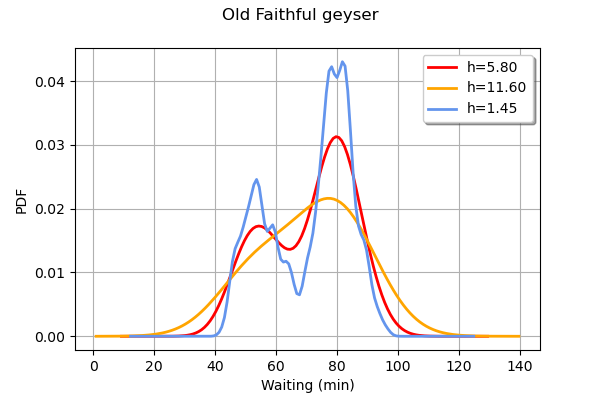

In [11]:
factory = ot.KernelSmoothing()

bandwidth = factory.computeSilvermanBandwidth(waiting)
ks = factory.build(waiting, bandwidth)
graph = ks.drawPDF()

bandwidth2 = 2.0 * bandwidth
ks2 = factory.build(waiting, bandwidth2)
graph2 = ks2.drawPDF()
graph2.setColors(["orange"])

bandwidth3 = 0.25 * bandwidth
ks3 = factory.build(waiting, bandwidth3)
graph3 = ks3.drawPDF()
graph3.setColors(["cornflowerblue"])

bandwidth_list = [bandwidth[0], bandwidth2[0], bandwidth3[0]]

graph.add(graph2)
graph.add(graph3)
legend = ["h=%.2f" % (b) for b in bandwidth_list]
graph.setLegends(legend)
graph.setTitle("Old Faithful geyser")
graph

On observe que 

* si la largeur de bande est trop petite, alors la distribution est trop piquée et 
* si la largeur de bande est trop grande, alors la distribution est trop lisse. 

En termes probabilistes, lorsque la largeur de bande $h$ diminue, alors 

* le biais diminue, 
* la variance augmente. 

## Exercice 2 : sensibilité du lissage à noyau à la règle de calcul


Silverman : 5.7981855716137165
Mixed : 2.4358530671843566
Plugin : 2.499769343288673


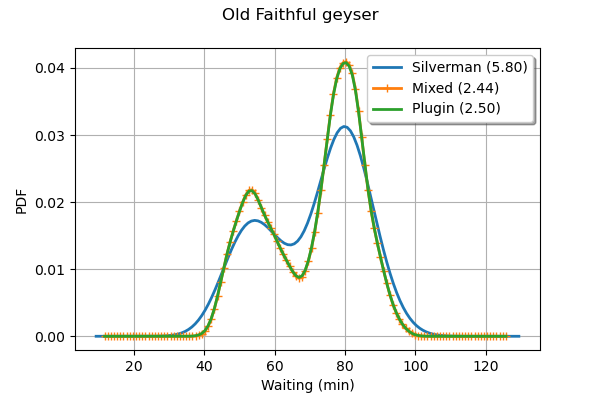

In [12]:
factory = ot.KernelSmoothing()

bandwidth_silverman = factory.computeSilvermanBandwidth(waiting)
print("Silverman :", bandwidth_silverman[0])
ks_silverman = factory.build(waiting, bandwidth_silverman)

bandwidth_mixed = factory.computeMixedBandwidth(waiting)
print("Mixed :", bandwidth_mixed[0])
ks_mixed = factory.build(waiting, bandwidth_mixed)

bandwidth_plugin = factory.computePluginBandwidth(waiting)
print("Plugin :", bandwidth_plugin[0])
ks_plugin = factory.build(waiting, bandwidth_plugin)

graph = ks_silverman.drawPDF()
graph_mixed = ks_mixed.drawPDF().getDrawable(0)
graph_mixed.setPointStyle("plus")
graph.add(graph_mixed)
graph_plugin = ks_plugin.drawPDF()
graph.add(graph_plugin)
legend = [
    "Silverman (%.2f)" % (bandwidth_silverman[0]),
    "Mixed (%.2f)" % (bandwidth_mixed[0]),
    "Plugin (%.2f)" % (bandwidth_plugin[0]),
]
graph.setLegends(legend)
graph.setTitle("Old Faithful geyser")
palette = ot.Drawable_BuildDefaultPalette(3)
graph.setColors(palette)
graph

## Exercice 3 : Données bidimensionnelles

In [13]:
def drawLevelSet2D(
    distribution, numberOfPointsInXAxis, alpha, sample, margin_factor=0.5
):
    """
    Plot a Minimum Level Set of a distribution and a sample.

    Compute the minimum volume Level Set (MVLS) of measure equal to alpha and get the
    corresponding density value (named threshold).
    Generate a sample of the distribution and draw it.
    Draw a contour plot for the distribution, where the PDF is equal to threshold.

    Parameters
    ----------
    distribution : ot.Distribution
        The distribution.
    numberOfPointsInXAxis : int
        The number of points to plot on the X axis.
    alpha : float, in (0, 1)
        The probabistic mass.
    sample : ot.Sample(size, 2)
        The sample.
    margin_factor : float, optional, > 0
        A margin to set the bounds of the MVLS. The default is 0.5.

    Returns
    -------
    graph : ot.Graph
        The plot.

    """
    levelSet, threshold = distribution.computeMinimumVolumeLevelSetWithThreshold(alpha)
    X1min = sample[:, 0].getMin()[0]
    X1max = sample[:, 0].getMax()[0]
    delta_X = margin_factor * (X1max - X1min)
    X1min -= delta_X
    X1max += delta_X
    X2min = sample[:, 1].getMin()[0]
    X2max = sample[:, 1].getMax()[0]
    delta_Y = margin_factor * (X2max - X2min)
    X2min -= delta_Y
    X2max += delta_Y
    xx = ot.Box([numberOfPointsInXAxis], ot.Interval([X1min], [X1max])).generate()
    yy = ot.Box([numberOfPointsInXAxis], ot.Interval([X2min], [X2max])).generate()
    xy = ot.Box(
        [numberOfPointsInXAxis, numberOfPointsInXAxis],
        ot.Interval([X1min, X2min], [X1max, X2max]),
    ).generate()
    data = distribution.computePDF(xy)
    graph = ot.Graph("", "X1", "X2", True, "topright")
    labels = ["%.2f%%" % (100 * alpha)]
    contour = ot.Contour(xx, yy, data, [threshold], labels)
    contour.setColor("black")
    sampleSize = sample.getSize()
    graph.setTitle(
        "%.2f%% of the distribution, sample size = %d" % (100 * alpha, sampleSize)
    )
    graph.add(contour)
    cloud = ot.Cloud(sample)
    graph.add(cloud)
    return graph

In [14]:
dataset = sample[:, [1, 2]]
dataset[:10]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=2 description=[Eruption (min),Waiting (min)] data=[[3.6,79],[1.8,54],[3.333,74],[2.283,62],[4.533,85],[2.883,55],[4.7,88],[3.6,85],[1.95,51],[4.35,85]]

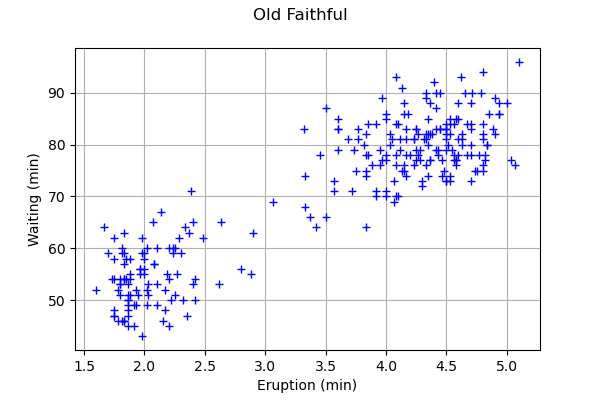

In [15]:
description = dataset.getDescription()

graph = ot.Graph("Old Faithful", description[0], description[1], True)
cloud = ot.Cloud(dataset)
graph.add(cloud)
graph

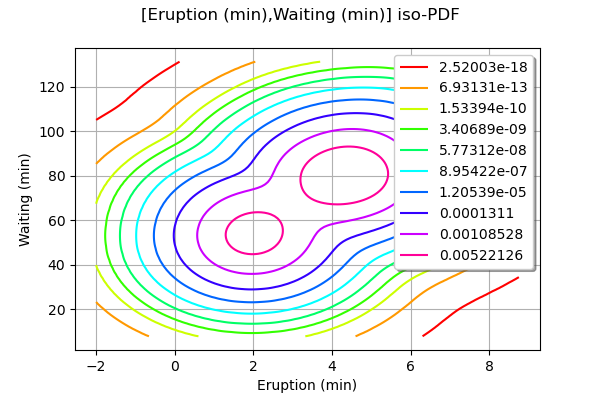

In [16]:
factory = ot.KernelSmoothing()

ks_distribution = factory.build(dataset)
graph = ks_distribution.drawPDF()
graph.setXTitle(description[0])
graph.setYTitle(description[1])
graph

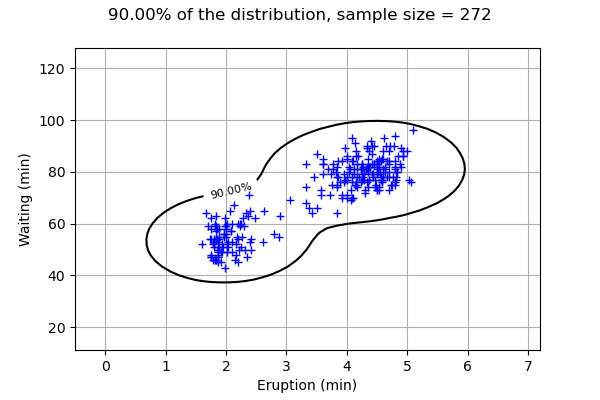

In [17]:
factory = ot.KernelSmoothing()

ks_distribution = factory.build(dataset)
alpha = 0.9
numberOfPointsInXAxis = 50
graph = drawLevelSet2D(
    ks_distribution, numberOfPointsInXAxis, alpha, dataset
)
graph.setXTitle(description[0])
graph.setYTitle(description[1])
graph

## Exercice 4 : Intervalle de confiance unidimensionnel

bandwidth =  5.589654179663481


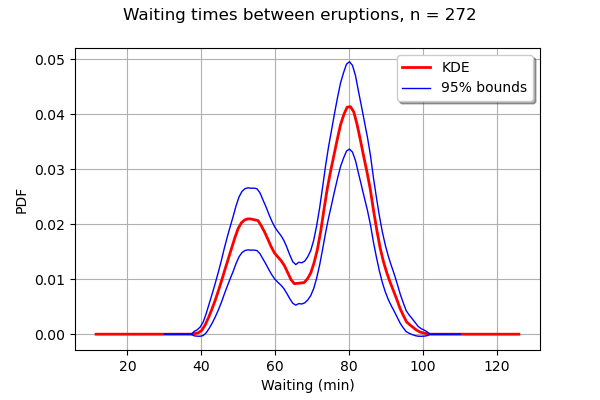

In [18]:
waiting_subsample = ot.Sample(waiting)
# Use this to reduce the sample size
# waiting_subsample = ot.Sample(waiting[0:10])
kernel = ot.Epanechnikov()
factory = ot.KernelSmoothing(kernel)
bandwidth = factory.computePluginBandwidth(waiting_subsample)[0]
print("bandwidth = ", bandwidth)
ks_distribution = factory.build(waiting_subsample, [bandwidth])

# Compute pointwise confidence bounds
alpha = 0.05
n_points = 100
rugosity = kernel.getRoughness()
sample_size = waiting_subsample.getSize()
sample_grid = ot.Sample.BuildFromPoint(np.linspace(30.0, 110.0, n_points))
confidence_interval = ot.Sample(n_points, 2)
for i in range(n_points):
    x = sample_grid[i, 0]
    ks_mean = ks_distribution.computePDF(x)  # f_hat(x)
    if ks_mean > 0.0:
        ks_sigma = np.sqrt(ks_mean * rugosity / (sample_size * bandwidth))
        ks_estimator = ot.Normal(ks_mean, ks_sigma)
        interval = ks_estimator.computeBilateralConfidenceInterval(1.0 - alpha)
        lower_bound = interval.getLowerBound()
        upper_bound = interval.getUpperBound()
        confidence_interval[i] = [lower_bound[0], upper_bound[0]]
    else:
        confidence_interval[i] = [ks_mean, ks_mean]


graph = ks_distribution.drawPDF()
graph.setLegends(["KDE"])
curve = ot.Curve(sample_grid, confidence_interval[:, 0])
curve.setLegend("%.0f%% bounds" % (100 * (1.0 - alpha)))
graph.add(curve)
curve = ot.Curve(sample_grid, confidence_interval[:, 1])
graph.add(curve)
graph.setTitle("Waiting times between eruptions, n = %d" % (sample_size))
graph

## Exercice 5 : sensibilité de l'histogramme à la largeur de classe


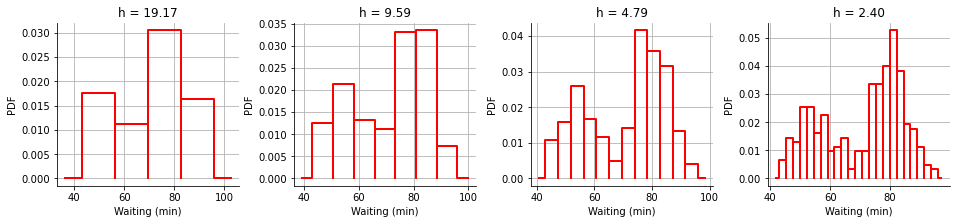

In [19]:
factory = ot.HistogramFactory()

classwidth = factory.computeBandwidth(waiting)

classwidth_list = [2.0 * classwidth, classwidth, 0.5 * classwidth, 0.25 * classwidth]
number_of_classwidths = len(classwidth_list)
grid = ot.GridLayout(1, number_of_classwidths)
for index in range(number_of_classwidths):
    classwidth = classwidth_list[index]
    histogram_distribution = factory.build(waiting, classwidth)
    graph = histogram_distribution.drawPDF()
    graph.setTitle("h = %.2f" % (classwidth))
    graph.setLegends([""])
    grid.setGraph(0, index, graph)

view = otv.View(grid, figure_kw={"figsize": (16.0, 3.0)})
pl.subplots_adjust(wspace = 0.3)

## Exercice 6 : sensibilité du lissage au noyau


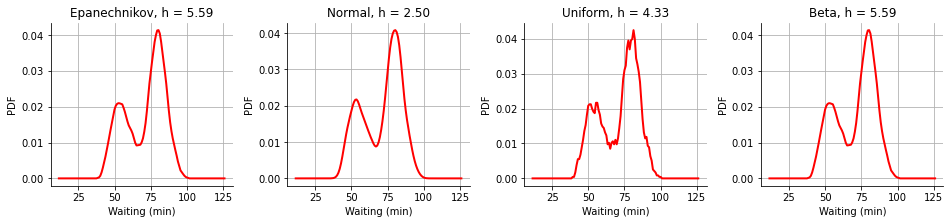

In [20]:
kernel_list = [ot.Epanechnikov(), ot.Normal(), ot.Uniform(), ot.Beta()]
number_of_kernels = len(kernel_list)

grid = ot.GridLayout(1, number_of_kernels)
for index in range(number_of_kernels):
    kernel = kernel_list[index]
    factory = ot.KernelSmoothing(kernel)
    bandwidth = factory.computePluginBandwidth(waiting)
    ks_distribution = factory.build(waiting, bandwidth)
    graph = ks_distribution.drawPDF()
    graph.setTitle("%s, h = %.2f" % (kernel.getName(), bandwidth[0]))
    graph.setLegends([""])
    grid.setGraph(0, index, graph)

view = otv.View(grid, figure_kw={"figsize": (16.0, 3.0)})
pl.subplots_adjust(wspace = 0.3)